In [1]:
cd /home/c01muya/vae-disentanglement/disentanglement_lib_pl

/home/c01muya/vae-disentanglement/disentanglement_lib_pl


In [2]:
import yaml
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from collections import defaultdict, namedtuple
from tqdm import tqdm

import torch
import torchvision.utils as vutils
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torchvision import transforms

from vae_experiment import VAEExperiment
from common.data_loader import DSpritesDataset
# import (correlated)dsprites

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

In [58]:
curr_dev = torch.device("cuda:2")
dset_name = 'dsprites_correlated'
dset_dir = '../datasets'
batch_size = 144
seed = 2048

ModelParams = namedtuple('ModelParams', ["z_dim", "l_dim", "num_labels" , "in_channels", 
                                        "image_size", "batch_size", "w_recon", "w_kld", 
                                         "controlled_capacity_increase", "max_c", "iterations_c",
                                        "w_tc", "w_infovae", "w_dipvae", "lambda_od", "lambda_d_factor",
                                        "encoder", "decoder", "loss_terms"])


experiment_config = dict(
        in_channels=1,
        image_size=64,
        LR=1e-4,
        weight_decay=0.0,       
        dataset=dset_name,
        datapath=dset_dir,
        droplast=True,        
        batch_size=batch_size,
        num_workers=8,
        pin_memory=True,
        seed=seed,
        evaluation_metrics=None,
        visdom_on=False
)

def load_vae_model(algo_name, checkpoint_path, curr_dev, 
                   model_params, exp_params):
    
    import models
    
    vae_model_class = getattr(models, algo_name)
    vae_model = vae_model_class(model_params)
        
    vae_experiment = VAEExperiment.load_from_checkpoint(
        checkpoint_path,
        map_location=curr_dev,
        vae_model=vae_model, 
        params=exp_params)

    vae_experiment = vae_experiment.to(curr_dev)

    return vae_experiment

def get_latent_activations(dataset, vae_model):

    batch_size = 32
    
    loader = DataLoader(dataset, batch_size=batch_size, shuffle = True, drop_last=True)
    latent_act_dict = defaultdict(list)
    batch_no = 0
    for x_batch, label_batch in tqdm(loader):
        #batch_no += 1
        #if batch_no > 2000:
        #    break
        # First we encode this batch
        x_batch = x_batch.to(curr_dev)
        #print(x_batch.shape)
        mu_batch, log_var_batch = vae_model.model.encode(x_batch)

        # Then, we get \mu and \sigma for this batch
        mu_batch = mu_batch.detach().cpu().numpy()
        log_var_batch = log_var_batch.detach().cpu().numpy()

        # and labels
        label_batch = label_batch.cpu().numpy()

        # using labels, we place all \mu's belonging to same class together
        for b in range(batch_size):

            label_of_this_x = label_batch[b]
            
            # for reach dimension
            for g, g_dim in enumerate(label_of_this_x): 
                
                latent_act_dict[g].append(g_dim.item())
                
                #g_dim_val = g_dim.item()
                #if g_dim_val in latent_act_dict[g].keys(): 
                #    latent_act_dict[g][g_dim_val].append(mu_batch[b][g].item())
                #else:
                #    latent_act_dict[g][g_dim_val] = []
                #    latent_act_dict[g][g_dim_val].append(mu_batch[b][g].item())
    
    return latent_act_dict

# $\beta$-VAE on dsprites with $\beta$-VAE metric

# $\beta$-VAE on dsprites_correlated with $\beta$-VAE metric

In [4]:
beta = 1.0
bvae_model_params = ModelParams(
    6, 6, 0, 1, 64, batch_size, 1.0, beta,
    False, 0, 0,
    0, 0, 0, 0, 0,
    ['SimpleGaussianConv64'],['SimpleConv64'], None
)

model_for_correlated_dsprites = load_vae_model(
    algo_name='BetaVAE', 
    checkpoint_path="../pl-dt-test/dsprites_correlated_beta1_vae/version_5/checkpoints/epoch=30-step=119039.ckpt", 
    curr_dev=curr_dev,
    model_params=bvae_model_params,
    exp_params=experiment_config
)

correlated_dsprites_dataset = DSpritesDataset(root="../datasets/dsprites/", split="train", correlated=True, transforms=transforms.ToTensor())

In [59]:
activations_for_correlated_dsprites = get_latent_activations(correlated_dsprites_dataset, 
                                                             model_for_correlated_dsprites)

100%|█████████████████████████████████████████| 20736/20736 [00:42<00:00, 489.56it/s]


In [60]:
activations_for_correlated_dsprites.keys()

dict_keys([0, 1, 2, 3, 4, 5])

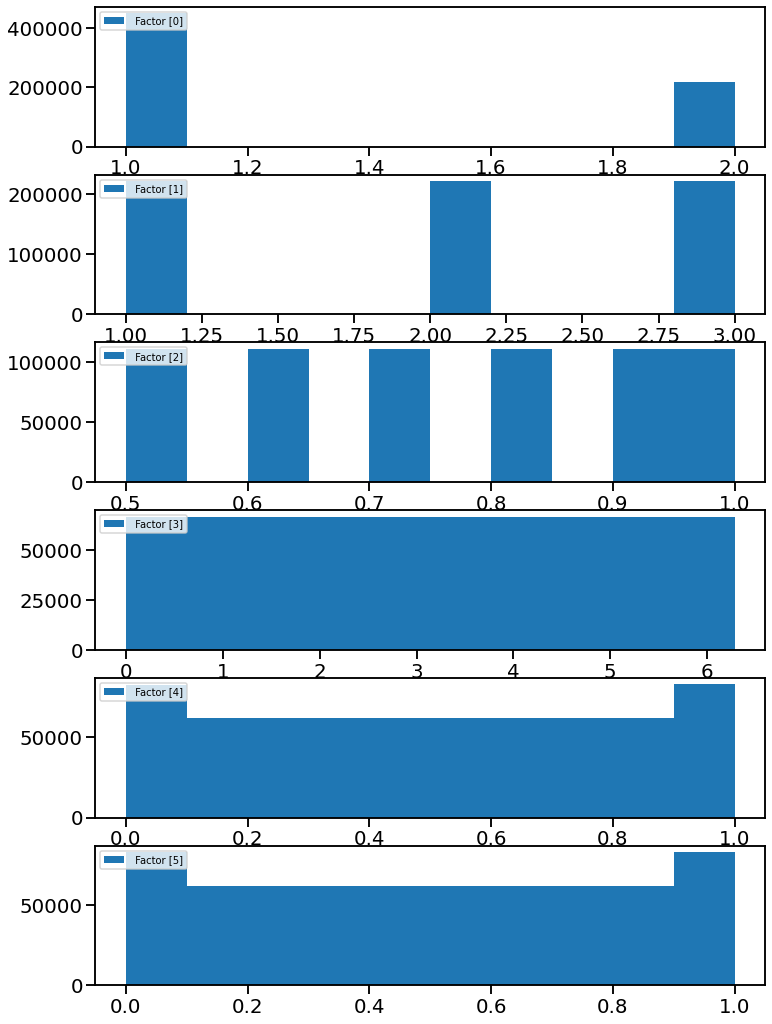

In [61]:
# plot hist of latent code
from matplotlib.pyplot import figure

#hist_figure = figure()

fig, axes = plt.subplots(len(activations_for_correlated_dsprites.keys()), figsize=(12,18))

for factor, value_dict  in activations_for_correlated_dsprites.items():
    
    axes[factor].hist(value_dict, label=f" Factor [{factor}]")
    axes[factor].legend(prop={'size': 10},loc='upper left')
        
# for factor, value_dict  in activations_for_correlated_dsprites.items():
    
#     for value, encoded_values in value_dict.items():
        
#         axes[factor].hist(encoded_values, label=f" Factor [{factor}] - Value [{value}]")
#         axes[factor].legend(prop={'size': 10},loc='upper left')



# Factor-VAE on dsprites with Factor-VAE metric

# Factor-VAE on dsprites_correlated with Factor-VAE metric